In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from tqdm import tqdm

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    x = np.clip(x, -500, 500)  # éviter overflow
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return (y_pred - y_true) / (y_pred * (1 - y_pred))


In [2]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
y = y.reshape(-1, 1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialisation optimisée des poids
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)  # He init
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)  # Xavier init
        self.b2 = np.zeros((1, output_size))

        # Variables pour les optimiseurs
        self.mW1 = self.mb1 = self.mW2 = self.mb2 = 0
        self.vW1 = self.vb1 = self.vW2 = self.vb2 = 0
        self.GW1 = self.Gb1 = self.GW2 = self.Gb2 = 0
        self.SW1 = self.Sb1 = self.SW2 = self.Sb2 = 0
        self.t = 0  # compteur pour Adam

    def forward(self, X):
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = sigmoid(self.Z2)  # clip à faire dans sigmoid pour éviter overflow
        return self.A2

    def backward(self, X, y, output):
        m = y.shape[0]
        dZ2 = binary_cross_entropy_derivative(y, output) * sigmoid_derivative(output)
        dW2 = self.A1.T.dot(dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dZ1 = dZ2.dot(self.W2.T) * relu_derivative(self.Z1)
        dW1 = X.T.dot(dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        return dW1, db1, dW2, db2

    def update_parameters_adam(self, grads, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        dW1, db1, dW2, db2 = grads
        self.t += 1
        for param, grad, m, v, name in zip(
            [self.W1, self.b1, self.W2, self.b2],
            [dW1, db1, dW2, db2],
            [self.mW1, self.mb1, self.mW2, self.mb2],
            [self.vW1, self.vb1, self.vW2, self.vb2],
            ['W1', 'b1', 'W2', 'b2']):
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** self.t)
            v_hat = v / (1 - beta2 ** self.t)
            update = lr * m_hat / (np.sqrt(v_hat) + epsilon)
            setattr(self, name, getattr(self, name) - update)
            setattr(self, 'm' + name, m)
            setattr(self, 'v' + name, v)

    def update_parameters_adagrad(self, grads, lr=0.01, epsilon=1e-8):
        dW1, db1, dW2, db2 = grads
        self.GW1 += dW1 ** 2
        self.Gb1 += db1 ** 2
        self.GW2 += dW2 ** 2
        self.Gb2 += db2 ** 2
        self.W1 -= lr * dW1 / (np.sqrt(self.GW1) + epsilon)
        self.b1 -= lr * db1 / (np.sqrt(self.Gb1) + epsilon)
        self.W2 -= lr * dW2 / (np.sqrt(self.GW2) + epsilon)
        self.b2 -= lr * db2 / (np.sqrt(self.Gb2) + epsilon)

    def update_parameters_rmsprop(self, grads, lr=0.001, gamma=0.9, epsilon=1e-8):
        dW1, db1, dW2, db2 = grads
        self.SW1 = gamma * self.SW1 + (1 - gamma) * dW1 ** 2
        self.Sb1 = gamma * self.Sb1 + (1 - gamma) * db1 ** 2
        self.SW2 = gamma * self.SW2 + (1 - gamma) * dW2 ** 2
        self.Sb2 = gamma * self.Sb2 + (1 - gamma) * db2 ** 2
        self.W1 -= lr * dW1 / (np.sqrt(self.SW1) + epsilon)
        self.b1 -= lr * db1 / (np.sqrt(self.Sb1) + epsilon)
        self.W2 -= lr * dW2 / (np.sqrt(self.SW2) + epsilon)
        self.b2 -= lr * db2 / (np.sqrt(self.Sb2) + epsilon)


In [4]:
def pack_weights(W1, b1, W2, b2):
    return np.concatenate([W1.ravel(), b1.ravel(), W2.ravel(), b2.ravel()])

def unpack_weights(w, input_size, hidden_size, output_size):
    W1 = w[:input_size * hidden_size].reshape(input_size, hidden_size)
    b1 = w[input_size * hidden_size : input_size * hidden_size + hidden_size].reshape(1, hidden_size)
    W2 = w[input_size * hidden_size + hidden_size : -output_size].reshape(hidden_size, output_size)
    b2 = w[-output_size:].reshape(1, output_size)
    return W1, b1, W2, b2

def forward_pass(w, X, input_size, hidden_size, output_size):
    W1, b1, W2, b2 = unpack_weights(w, input_size, hidden_size, output_size)
    A1 = relu(X.dot(W1) + b1)
    A2 = sigmoid(A1.dot(W2) + b2)
    return A2

def loss_func(w, X, y, input_size, hidden_size, output_size):
    y_pred = forward_pass(w, X, input_size, hidden_size, output_size)
    return binary_cross_entropy(y, y_pred)

def loss_grad(w, X, y, input_size, hidden_size, output_size):
    W1, b1, W2, b2 = unpack_weights(w, input_size, hidden_size, output_size)
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)
    Z2 = A1.dot(W2) + b2
    A2 = sigmoid(Z2)
    m = y.shape[0]
    dZ2 = binary_cross_entropy_derivative(y, A2) * sigmoid_derivative(A2)
    dW2 = A1.T.dot(dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dZ1 = dZ2.dot(W2.T) * relu_derivative(Z1)
    dW1 = X.T.dot(dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    return pack_weights(dW1, db1, dW2, db2)

initial_weights = np.random.randn(2 * 10 + 10 + 10 * 1 + 1) * 0.01
result = minimize(fun=loss_func, x0=initial_weights, jac=loss_grad,
                  args=(X_train, y_train, 2, 10, 1), method='BFGS', options={'maxiter': 2000})
y_pred_bfgs = forward_pass(result.x, X_test, 2, 10, 1) > 0.5
acc_bfgs = accuracy_score(y_test, y_pred_bfgs)


In [5]:
# Définition des fonctions d'entraînement manquantes

def train_sgd(X_train, y_train, X_test, y_test, hidden_size=10, epochs=2000, lr=0.01):
    model = NeuralNetwork(input_size=2, hidden_size=hidden_size, output_size=1)
    loss_history = []
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in indices:
            x_i = X_train[i:i+1]
            y_i = y_train[i:i+1]
            output = model.forward(x_i)
            grads = model.backward(x_i, y_i, output)
            model.W1 -= lr * grads[0]
            model.b1 -= lr * grads[1]
            model.W2 -= lr * grads[2]
            model.b2 -= lr * grads[3]
        loss = binary_cross_entropy(y_train, model.forward(X_train))
        loss_history.append(loss)
    y_pred = model.forward(X_test) > 0.5
    acc = accuracy_score(y_test, y_pred)
    return loss_history, acc

def train_momentum(X_train, y_train, X_test, y_test, hidden_size=10, epochs=2000, lr=0.01, mu=0.9):
    model = NeuralNetwork(input_size=2, hidden_size=hidden_size, output_size=1)
    vW1 = np.zeros_like(model.W1)
    vb1 = np.zeros_like(model.b1)
    vW2 = np.zeros_like(model.W2)
    vb2 = np.zeros_like(model.b2)
    loss_history = []
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in range(0, len(indices), 32):
            idx = indices[i:i+32]
            x_batch = X_train[idx]
            y_batch = y_train[idx]
            output = model.forward(x_batch)
            grads = model.backward(x_batch, y_batch, output)
            vW1 = mu * vW1 - lr * grads[0]
            vb1 = mu * vb1 - lr * grads[1]
            vW2 = mu * vW2 - lr * grads[2]
            vb2 = mu * vb2 - lr * grads[3]
            model.W1 += vW1
            model.b1 += vb1
            model.W2 += vW2
            model.b2 += vb2
        loss = binary_cross_entropy(y_train, model.forward(X_train))
        loss_history.append(loss)
    y_pred = model.forward(X_test) > 0.5
    acc = accuracy_score(y_test, y_pred)
    return loss_history, acc

def train_nesterov(X_train, y_train, X_test, y_test, hidden_size=10, epochs=2000, lr=0.01, mu=0.9):
    model = NeuralNetwork(input_size=2, hidden_size=hidden_size, output_size=1)
    vW1 = np.zeros_like(model.W1)
    vb1 = np.zeros_like(model.b1)
    vW2 = np.zeros_like(model.W2)
    vb2 = np.zeros_like(model.b2)
    loss_history = []
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        for i in range(0, len(indices), 32):
            idx = indices[i:i+32]
            x_batch = X_train[idx]
            y_batch = y_train[idx]
            # lookahead step
            model.W1 += mu * vW1
            model.b1 += mu * vb1
            model.W2 += mu * vW2
            model.b2 += mu * vb2
            # compute gradients at lookahead
            output = model.forward(x_batch)
            grads = model.backward(x_batch, y_batch, output)
            # restore weights
            model.W1 -= mu * vW1
            model.b1 -= mu * vb1
            model.W2 -= mu * vW2
            model.b2 -= mu * vb2
            # apply update
            vW1 = mu * vW1 - lr * grads[0]
            vb1 = mu * vb1 - lr * grads[1]
            vW2 = mu * vW2 - lr * grads[2]
            vb2 = mu * vb2 - lr * grads[3]
            model.W1 += vW1
            model.b1 += vb1
            model.W2 += vW2
            model.b2 += vb2
        loss = binary_cross_entropy(y_train, model.forward(X_train))
        loss_history.append(loss)
    y_pred = model.forward(X_test) > 0.5
    acc = accuracy_score(y_test, y_pred)
    return loss_history, acc

# Entraînement pour les optimiseurs manquants (à exécuter avant le résumé)
loss_sgd, acc_sgd = train_sgd(X_train, y_train, X_test, y_test)
loss_momentum, acc_momentum = train_momentum(X_train, y_train, X_test, y_test)
loss_nesterov, acc_nesterov = train_nesterov(X_train, y_train, X_test, y_test)


In [6]:
def train_with_optimizer(name, update_func, X_train, y_train, X_test, y_test, lr=0.01, epochs=2000):
    model = NeuralNetwork(input_size=2, hidden_size=10, output_size=1)
    loss_history = []
    for epoch in range(epochs):
        output = model.forward(X_train)
        loss = binary_cross_entropy(y_train, output)
        grads = model.backward(X_train, y_train, output)
        update_func(model, grads, lr)
        loss_history.append(loss)
    y_pred = model.forward(X_test) > 0.5
    acc = accuracy_score(y_test, y_pred)
    return loss_history, acc

# Entraînement pour Adam, AdaGrad et RMSprop

loss_adam, acc_adam = train_with_optimizer("Adam", lambda m, g, lr: m.update_parameters_adam(g, lr),
                                           X_train, y_train, X_test, y_test)

loss_adagrad, acc_adagrad = train_with_optimizer("AdaGrad", lambda m, g, lr: m.update_parameters_adagrad(g, lr),
                                                 X_train, y_train, X_test, y_test)

loss_rmsprop, acc_rmsprop = train_with_optimizer("RMSprop", lambda m, g, lr: m.update_parameters_rmsprop(g, lr),
                                                 X_train, y_train, X_test, y_test)

print("Précision Adam    :", round(acc_adam * 100, 2), "%")
print("Précision AdaGrad :", round(acc_adagrad * 100, 2), "%")
print("Précision RMSprop :", round(acc_rmsprop * 100, 2), "%")


Précision Adam    : 100.0 %
Précision AdaGrad : 90.5 %
Précision RMSprop : 100.0 %


GD (normal) entraîné — précision : 90.0 %
GD (bruité) entraîné — précision : 82.0 %
Entraînement CG terminé — précision : 89.0 %

RÉSUMÉ DES PRÉCISIONS :
Précision SGD          : 100.0 %
Précision Momentum     : 100.0 %
Précision Nesterov     : 100.0 %
Précision Adam         : 100.0 %
Précision AdaGrad      : 96.0 %
Précision RMSprop      : 100.0 %
Précision BFGS         : 99.5 %
Précision CG           : 89.0 %
Précision GD (normal)  : 90.0 %
Précision GD (bruité)  : 82.0 %


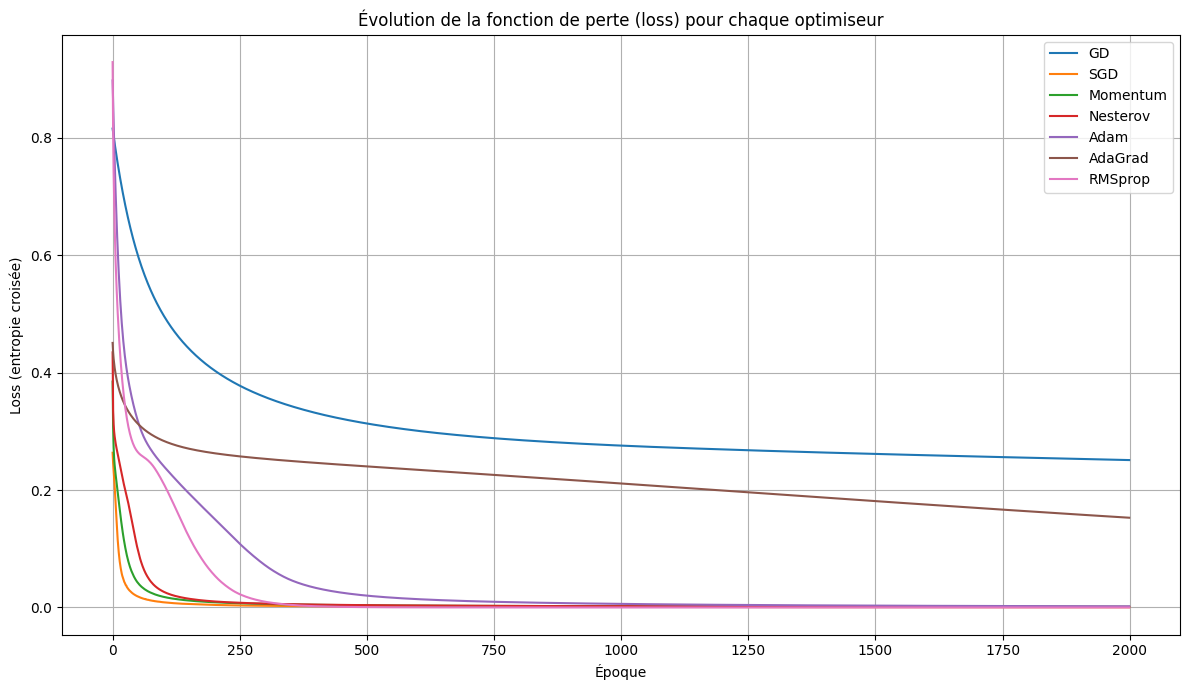

In [ ]:
# Fonction GD classique
def train_gd(X_train, y_train, X_test, y_test, hidden_size=10, epochs=2000, lr=0.01):
    model = NeuralNetwork(input_size=2, hidden_size=hidden_size, output_size=1)
    loss_history = []
    for epoch in range(epochs):
        output = model.forward(X_train)
        loss = binary_cross_entropy(y_train, output)
        grads = model.backward(X_train, y_train, output)
        model.W1 -= lr * grads[0]
        model.b1 -= lr * grads[1]
        model.W2 -= lr * grads[2]
        model.b2 -= lr * grads[3]
        loss_history.append(loss)
    y_pred = model.forward(X_test) > 0.5
    acc = accuracy_score(y_test, y_pred)
    return loss_history, acc

# Générer les données bruitées 
try:
    X_train_n
except NameError:
    from sklearn.datasets import make_moons
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    X_noisy, y_noisy = make_moons(n_samples=1000, noise=0.3, random_state=42)
    y_noisy = y_noisy.reshape(-1, 1)
    X_noisy = StandardScaler().fit_transform(X_noisy)
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=42)

# Entraînement GD (normal + bruité)
loss_gd, acc_gd = train_gd(X_train, y_train, X_test, y_test)
print("GD (normal) entraîné — précision :", round(acc_gd * 100, 2), "%")

loss_gd_n, acc_gd_n = train_gd(X_train_n, y_train_n, X_test_n, y_test_n)
print("GD (bruité) entraîné — précision :", round(acc_gd_n * 100, 2), "%")

# Entraînement CG
initial_weights_cg = np.random.randn(2 * 10 + 10 + 10 * 1 + 1) * 0.01
result_cg = minimize(
    fun=loss_func,
    x0=initial_weights_cg,
    jac=loss_grad,
    args=(X_train, y_train, 2, 10, 1),
    method='CG',
    options={'maxiter': 2000}
)
y_pred_cg = forward_pass(result_cg.x, X_test, 2, 10, 1) > 0.5
acc_cg = accuracy_score(y_test, y_pred_cg)
print(" Entraînement CG terminé — précision :", round(acc_cg * 100, 2), "%")

# Résumé des précisions finales
print("\n RÉSUMÉ DES PRÉCISIONS :")
for label, acc_var in [
    ("SGD",        "acc_sgd"),
    ("Momentum",   "acc_momentum"),
    ("Nesterov",   "acc_nesterov"),
    ("Adam",       "acc_adam"),
    ("AdaGrad",    "acc_adagrad"),
    ("RMSprop",    "acc_rmsprop"),
    ("BFGS",       "acc_bfgs"),
    ("CG",         "acc_cg"),
    ("GD (normal)", "acc_gd"),
    ("GD (bruité)", "acc_gd_n"),
]:
    try:
        print(f"Précision {label:<13}: {round(eval(acc_var) * 100, 2)} %")
    except:
        print(f"{label:<13}:  non défini")

# Affichage des courbes de perte
plt.figure(figsize=(12, 7))
for name, var in [
    ("GD",        "loss_gd"),
    ("SGD",       "loss_sgd"),
    ("Momentum",  "loss_momentum"),
    ("Nesterov",  "loss_nesterov"),
    ("Adam",      "loss_adam"),
    ("AdaGrad",   "loss_adagrad"),
    ("RMSprop",   "loss_rmsprop"),
]:
    try:
        plt.plot(eval(var), label=name)
    except:
        print(f"Courbe non disponible pour {name}")

plt.title("Évolution de la fonction de perte (loss) pour chaque optimiseur")
plt.xlabel("Époque")
plt.ylabel("Loss (entropie croisée)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("courbe_loss_10_optimiseurs.png")
plt.show()
